# Preparatory code

## Imports

In [67]:
from d2l import torch as d2l
import numpy as np
from torch import nn
import torchvision
from torchvision.transforms import v2
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

## Class support functions

In [27]:
def add_to_class(Class):    #@save
    """Register functions as methods in the created class"""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

# Dataloader

First, a generic data loader.

In [72]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class for data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)
    
    def visualize(self, batch, nrows = 1, ncols = 8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        grid = torchvision.utils.make_grid(X[:8, :, :, :])
        show(grid)



plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

On to the implementation of our dataloader.
The structure of `self.train` (or `self.val`) is the following:
* Input images (as an array)
* Tuple (image tensor, label)
* label is an int
* image tensor is (channels, height, width)


In [29]:
def open_image(path):
    return NotImplementedError

In [60]:
def open_image_placeholder(path, transf):
    img = []
    for f in os.listdir(path):
        img.append((transf(torchvision.io.read_image(f"{path}/{f}")), 0))

    
    return img

In [62]:
def test_resize(path):
    f = v2.Compose([v2.ToImage(), v2.Resize(28)])
    return f(cv2.imread(f'{path}/{os.listdir(path)[0]}')).shape

test_resize('../dataset/TestA/Basophil')

torch.Size([3, 28, 28])

torch.Size([64, 3, 28, 28]) torch.uint8 torch.Size([64]) torch.int64


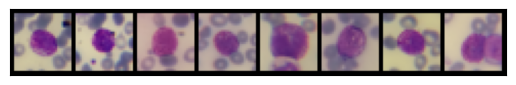

In [73]:
class CroppedCells(DataModule):
    """The dataset of cropped cells."""
    def __init__(self, transf = v2.Compose([v2.Resize((28, 28)), v2.ToTensor()]), resize = (28, 28), batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train = open_image_placeholder('../dataset/TestA/Basophil', transf=transf)

    def get_dataloader(self, train=True):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels"""
        labels = ['Basophil']
        return [labels[int(i)] for i in indices]
    
data = CroppedCells()
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)
data.visualize(next(iter(data.train_dataloader())))

# Models

In [ ]:
class Module(nn.Module, d2l.HyperParameters):   #@save
    """The base class of models"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, "net"), "Neural network is defined"
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation"""

        assert hasattr(self, "trainer"), "Trainer is not initiated"
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            '''
            Note: backward slash means newline. Forward slash is the usual division. 
            '''
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
            
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

## ResNet

# Training

## ResNet v0.1